##Installing Libraries

In [17]:
!apt install ffmpeg
!pip install plotly bokeh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from google.colab import output
import seaborn as sns
import matplotlib.animation as animation
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal


## Probability Distribution Function

this is for when the last time the object was seen

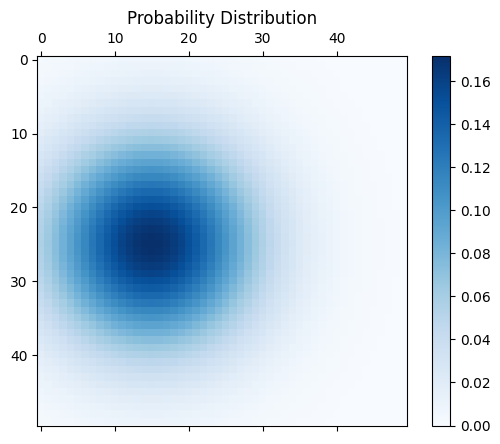

In [19]:
'''
n: int n defines n by n size of grid
center: int c defines the center of the circle where object was last seen
radius: int r defines the radius of of the circle, note the intensity of the circle follows a normal distribution from the center
graph: bool graph determines if user wants to graph the output, defult is False
'''

def create_probability_distribution_grid(n, center, radius, graph = False):
    matrix = np.zeros((n, n))
    center_x, center_y = center
    x, y = np.meshgrid(np.arange(n), np.arange(n))

    # Calculate the Gaussian distribution
    covariance = np.eye(2) * (radius**2)
    mv_normal = multivariate_normal(mean=[center_x, center_y], cov=covariance)
    prob_values = mv_normal.pdf(np.column_stack((x.flatten(), y.flatten())))
    prob_matrix = prob_values.reshape((n, n))

    # Normalize the matrix so that the values add up to 1
    matrix = prob_matrix / np.sum(prob_matrix)

    if graph:
      # Create a figure and axis
      fig, ax = plt.subplots()

      # Display the matrix with a heatmap and annotate with probability values
      cax = ax.matshow(matrix*100, cmap='Blues', vmin=0, vmax=np.max(matrix)*100)

      # Add a colorbar to the plot
      cbar = fig.colorbar(cax)

      if n < 26:
        # Annotate with probability values
        for i in range(n_size):
            for j in range(n_size):
                text = ax.text(j, i, f'{matrix[i, j]*100:.1f}', ha='center', va='center', color='black', fontsize=8)

      # Show the plot
      plt.title("Probability Distribution")
      plt.show()

    return matrix

# Example usage:
n_size = 50
center_coords = (15, 25)
circle_radius = 10

prob_dist = create_probability_distribution_grid(n_size, center_coords, circle_radius, True)

## This code is similar to the one above but it is not a probability density map so that all the cells add up to 1 but rather a probability map for how likely I am to find the object in each square given it is there (based on the hypothetical depth of the water in each square.) So in this example the circles can represent underwater caverns that or places of greater depth that even when checking finding a lost object may be less probable in.

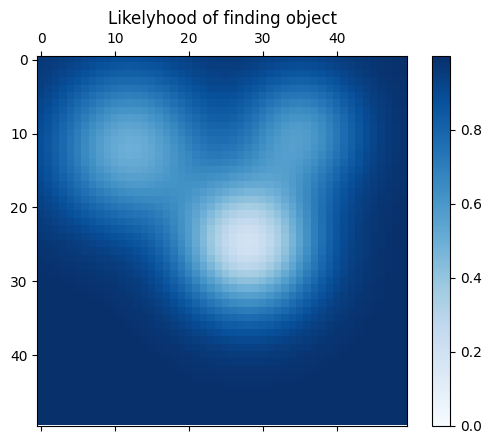

In [20]:

def create_matrix(n, circles, graph = False):
    matrix = np.ones((n, n))

    for circle in circles:
        center_x, center_y, radius, likelihood = circle

        for i in range(n):
            for j in range(n):
                distance = np.sqrt((i - center_x)**2 + (j - center_y)**2)
                matrix[i, j] -= likelihood * np.exp(-(distance / radius)**2)

    if graph:
      # Create a figure and axis
      fig, ax = plt.subplots()

      # Display the matrix with a heatmap
      cax = ax.matshow(matrix, cmap='Blues', vmin=0, vmax=np.max(matrix))

      # Add a colorbar to the plot
      cbar = fig.colorbar(cax)

      # Show the plot
      plt.title("Likelyhood of finding object")
      plt.show()


    return matrix

# Example usage:
n_size = 50

# Define circles as (center_x, center_y, radius, likelihood of not finding object)
circles = [(12, 12, 10, 0.5), (25, 28, 9, 0.8), (10, 35, 8, 0.4)]

difficulty_matrix = create_matrix(n_size, circles, True)


## Combination of the previous 2 matrices

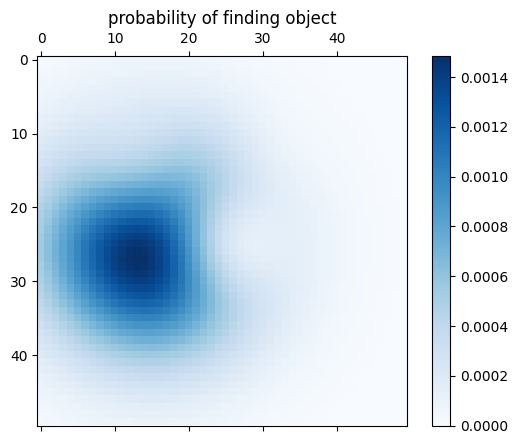

In [21]:
prob_of_find_matrix = difficulty_matrix * prob_dist
# Create a figure and axis
fig, ax = plt.subplots()

# Display the matrix with a heatmap
cax = ax.matshow(prob_of_find_matrix, cmap='Blues', vmin=0, vmax=np.max(prob_of_find_matrix))

# Add a colorbar to the plot
cbar = fig.colorbar(cax)

# Show the plot
plt.title("probability of finding object")
plt.show()



## Undewater Wave Dynamics

In [22]:
'''
waves
size: int n, defines n by n size grid
width_h/_v : int w, define the width of the wave
peak_h/_v : int p, define where the wave peaks relative to the width
set width and peak variable of eaither vertical or horizontal bar equal to 0 to not consider the diretion
off_h/_v : int c, set close to peak values to create a wave with a more "edged" look
h_/v_dir  : char "u" for up, "d" for down for the horizontal wave, "l" for left, "r" for right for vertical wave
'''
def waves(size, width_h = 12, peak_h = 6, width_v = 12, peak_v = 6, off_h = 0, off_v= 0, h_dir = "d", v_dir = "r"):

  initial_matrix = np.zeros((size, size))

  # Create a figure and axis
  fig, ax = plt.subplots()

  # Display the initial matrix
  cax = ax.matshow(initial_matrix, cmap='Blues', vmin=0, vmax=1)

  # Add a colorbar to the plot
  cbar = fig.colorbar(cax)

  # Function to update the animation frames
  def update(frame):
      initial_matrix = np.zeros((size, size))
      for i in range(width_h):
        if h_dir == "d":
          initial_matrix[(frame+i) % size, :] =  np.exp(-(i - peak_h-off_h)**2 / 20.0)
        elif h_dir == "u":
          initial_matrix[(-frame-i) % size, :] =  np.exp(-(i - peak_h-off_h)**2 / 20.0)
      for j in range(width_v):
        if v_dir == "r":
          initial_matrix[:, (frame+j) % size] +=  np.exp(-(j - peak_v-off_v)**2 / 20.0)
        elif v_dir == "l":
          initial_matrix[:, (-frame-j) % size] +=  np.exp(-(j - peak_h-off_h)**2 / 20.0)

      # Update the data of the existing plot
      cax.set_array(initial_matrix)

  # Create an animation
  animation = FuncAnimation(fig, update, frames=range(50), interval=500)
  return animation

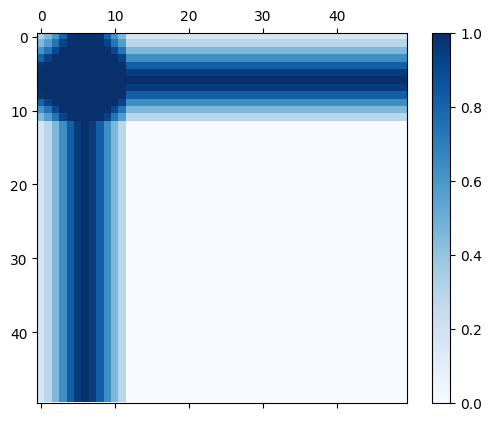

In [23]:
ani = waves(50)

In [16]:
# below is the part which makes it work on Colab
rc('animation', html='jshtml')
ani    # or HTML(anim.to_jshtml())

## Update Code

In [57]:
'''
x and y define the point which is searched and r is the radious of the search
intensity [0, 1] is the likelyhood of
'''
def search_update(likelyhood_matrix, difficulty_matrix, x, y, plot = False):
  p_is_there_and_not_found = (likelyhood_matrix[x][y]*(1-difficulty_matrix[x][y]))/((1-likelyhood_matrix[x][y])+likelyhood_matrix[x][y]*(1-difficulty_matrix[x][y]))
  #likelyhood_matrix[x][y] = p_is_there_and_not_found
  likelyhood_matrix[x][y] = 0


  total_sum = np.sum(likelyhood_matrix)
  for xs, ys in np.ndindex(likelyhood_matrix.shape):
    if xs != x and ys != y:
      likelyhood_matrix[xs][ys] = likelyhood_matrix[xs][ys] / ((1 - likelyhood_matrix[xs][ys]) + likelyhood_matrix[xs][ys] * (1 - likelyhood_matrix[xs][ys])*difficulty_matrix[xs][ys])


  if plot:
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Display the initial matrix
    cax = ax.matshow(likelyhood_matrix, cmap='Blues')

    # Add a colorbar to the plot
    cbar = fig.colorbar(cax)


  return likelyhood_matrix

In [142]:
def square_search(start, num_legs ,length, increment, max_x, max_y):
  d = [(1, 0),(0, 1),(-1, 0),(0, -1)]

  current = start
  yield current

  for i in range(num_legs):
    dx, dy = d[i%4]

    for _ in range(length + i * increment):
      next_p = (current[0] + dx, current[1] + dy)

      if 0 <= next_p[0] < max_x and 0 <= next_p[1] < max_y:
        current = next_p
        yield next_p


In [146]:
def prob_dist_update(likelyhood_matrix, difficulty_matrix):

  # Create a figure and axis
  fig, ax = plt.subplots()

  # Display the initial matrix
  cax = ax.matshow(likelyhood_matrix, cmap='Blues')

  # Add a colorbar to the plot
  cbar = fig.colorbar(cax)


  p = difficulty_matrix * likelyhood_matrix
  start = np.unravel_index(p.argmax(), p.shape)

  find_point = square_search(start, 12, 1, 1, likelyhood_matrix.shape[0], likelyhood_matrix.shape[1])

  # Function to update the animation frames
  def update(frame):
    prob_of_find_matrix = difficulty_matrix * likelyhood_matrix
    try:
      (x, y) = next(find_point)
    except StopIteration:
      #print("STOP ITERATION")
      return

    new_matrix = search_update(likelyhood_matrix, difficulty_matrix, x, y)

    # Update the data of the existing plot
    cax.set_array(new_matrix)

  # Create an animation
  animation = FuncAnimation(fig, update, frames=range(50), interval=500)
  return animation

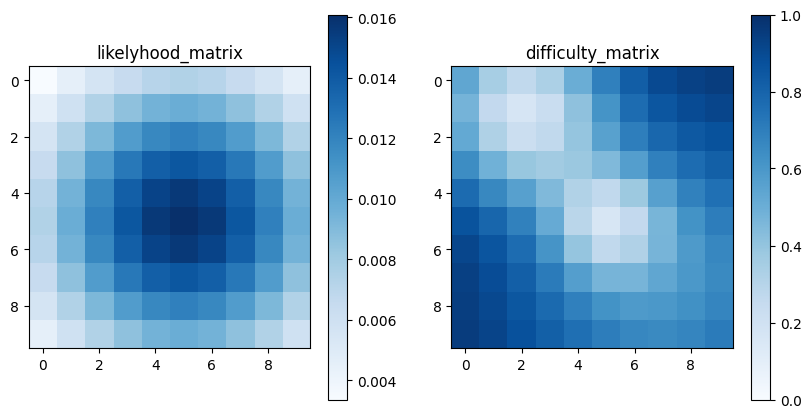

x is: 6 and y is: 2


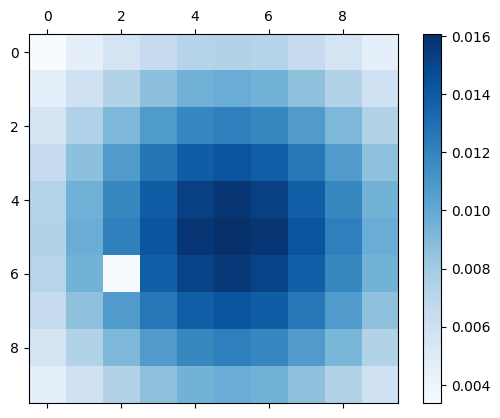

In [147]:
# Example usage:
n_size = 10

# Define circles as (center_x, center_y, radius, likelihood of not finding object)
circles = [(5, 5, 2, 0.5), (1, 2, 3, 0.8), (7, 7, 5, 0.4)]

center_coords = (5, 5)
circle_radius = 4

likelyhood_matrix = create_probability_distribution_grid(n_size, center_coords, circle_radius)
difficulty_matrix = create_matrix(n_size, circles)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the first matrix in the first subplot
axs[0].imshow(likelyhood_matrix, cmap='Blues')
axs[0].set_title('likelyhood_matrix')

# Display the second matrix in the second subplot
axs[1].imshow(difficulty_matrix, cmap='Blues', vmin=0, vmax=1)
axs[1].set_title('difficulty_matrix')

# Add a colorbar to each subplot
for ax in axs:
    cbar = fig.colorbar(ax.images[0], ax=ax, orientation='vertical')

plt.show()

anim = prob_dist_update(likelyhood_matrix, difficulty_matrix)

In [148]:
# below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim    # or HTML(anim.to_jshtml())

x is: 7 and y is: 2
x is: 7 and y is: 3
x is: 7 and y is: 4
x is: 6 and y is: 4
x is: 5 and y is: 4
x is: 4 and y is: 4
x is: 4 and y is: 3
x is: 4 and y is: 2
x is: 4 and y is: 1
x is: 4 and y is: 0
x is: 5 and y is: 0
x is: 6 and y is: 0
x is: 7 and y is: 0
x is: 8 and y is: 0
x is: 9 and y is: 0
x is: 9 and y is: 1
x is: 9 and y is: 2
x is: 9 and y is: 3
x is: 9 and y is: 4
x is: 9 and y is: 5
x is: 9 and y is: 6
x is: 8 and y is: 6
x is: 7 and y is: 6
x is: 6 and y is: 6
x is: 5 and y is: 6
x is: 4 and y is: 6
x is: 3 and y is: 6
x is: 2 and y is: 6
x is: 2 and y is: 5
x is: 2 and y is: 4
x is: 2 and y is: 3
x is: 2 and y is: 2
x is: 2 and y is: 1
x is: 2 and y is: 0
x is: 3 and y is: 0
x is: 4 and y is: 0
x is: 5 and y is: 0
x is: 6 and y is: 0
x is: 7 and y is: 0
x is: 8 and y is: 0
x is: 9 and y is: 0
x is: 9 and y is: 1
x is: 9 and y is: 2
x is: 9 and y is: 3
x is: 9 and y is: 4
x is: 9 and y is: 5
x is: 9 and y is: 6
x is: 9 and y is: 7
x is: 9 and y is: 8
x is: 9 and y is: 9


## Next step is to create an update function that updates the probabilites of being found somewhere in the matrix given a grid is checked, later on an optimal search pattern could be input to the function to fully model our problem.